In [1]:
import pandas as pd
import numpy as np
pd.set_option("display.show_dimensions", False)
pd.set_option("display.float_format", "{:4.2g}".format)

In [ ]:
# 設定 matplotlib 支援中文字型
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

plt.rcParams["font.family"] = "simsun" # 可以直接修改設定字典，設定預設字型，這樣就不需要在每次繪製文字時設定字型了
plt.rcParams['axes.unicode_minus']=False    # 當座標軸上的 負號 無法正常顯示時，需加這行 code
font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=14)
# plt.xlabel(u"時間", fontproperties=font)

In [ ]:

from IPython.core.magic import register_line_magic

@register_line_magic
def C(line):
    from IPython.core.getipython import get_ipython
    from fnmatch import fnmatch

    line = line.strip()
    if ' ' in line:
        idx_space = line.index(' ')
        space_num = line[:idx_space]
        if space_num.isdecimal():
            space_num = int(space_num)
            line = line[idx_space:]
        else:
            space_num = 5
    else:
        space_num = 5

    output_dict = {}
    cmds = line.split(';')
    for cmd in cmds:
        cmd = cmd.strip()
        if cmd != "":
            output_dict[cmd] = repr(eval(cmd)).split("\n")

    str_maxlen_in_cols = [max(len(cmd), len(max(data, key=len))) for cmd, data in output_dict.items()]
    data_row_max = max([len(v) for v in output_dict.values()])

    out_lines = [""]*(data_row_max+2)

    space=''
    for i, (cmd, data) in enumerate(output_dict.items()):
        w = str_maxlen_in_cols[i]

        out_lines[0]+=space+f'{cmd:^{w}}'
        out_lines[1]+=space+"-"*w
        for j, d in enumerate(data, 2):
            out_lines[j]+=space+f'{d:{w}}'

        if len(data) < data_row_max:
            for j in range(len(data)+2, data_row_max+2):
                out_lines[j]+=space+' '*w
        
        space = ' '*space_num

    for line in out_lines:
        print(line)

# Pandas-方便的資料分析庫

In [2]:
import pandas as pd
pd.__version__

'1.1.1'

## Pandas中的資料物件

### `Series`物件

- `Series`是`Pandas`中最基本的物件，它定義了 Numpy 的 ndarray 物件的介面 `__array__()`，因此可以用 Numpy 的陣列處理函數直接對 `Series` 物件進行處理。
- `Series`物件除了支援使用位置索引(`s[2]`)存取元素之外，還可以使用索引標籤(`s['d']`)作為索引存取元素。
- 每個`Serise`物件實際上都由兩個陣例組成:
  - `index`: 它是從 ndarray 陣列繼承的 `Index 索引物件`，儲存標籤資訊。若建立`Series物件`時不指定 `index`，將自動建立一個表示位置索引的索引。
  - `values`: 儲存元素值的 ndarray 陣列，Numpy 的函數都對此陣列進行處理。

In [3]:
# 下面建立一個 Series 物件，並檢視上述兩個屬性(index, values)
s = pd.Series([1, 2, 3, 4, 5], index=["a", "b", "c", "d", "e"])
print(u"　索引:", s.index)
print(u"值陣列:", s.values)

　索引: Index(['a', 'b', 'c', 'd', 'e'], dtype='object')
值陣列: [1 2 3 4 5]


In [4]:
# Series 物件的索引運算同時支援位置(s[2])和標籤(s['d'])兩種形式
print(u"位置索引   s[2]:", s[2])
print(u"標簽索引 s['d']:", s['d'])

位置索引   s[2]: 3
標簽索引 s['d']: 4


In [5]:
# Series 物件還支援 位置切片(s[1:3]) 和 標籤切片(s['b':'d'])。
# - `位置切片` 遵循 python 的切片規則，包含起始位置，但不包含結束位置。
# - `標籤切片` 同時包含 起始標籤 和 結束標籤。
# %C 5 s[1:3]; s['b':'d']
print(s[1:3])
print('-'*20)
print(s['b':'d'])

b    2
c    3
dtype: int64
--------------------
b    2
c    3
d    4
dtype: int64


In [6]:
# 和 ndarry 陣列一樣，Series 還可以使用 位置清單(s[[1,3,2]]) 或 位置陣列 存取元素。
# 也可以用 標簽清單(s[['b','d','c']]) 或 標籤陣列。
# %C 5 s[[1,3,2]]; s[['b','d','c']]
print(s[[1,3,2]])
print("-"*20)
print(s[['b','d','c']])

b    2
d    4
c    3
dtype: int64
--------------------
b    2
d    4
c    3
dtype: int64


In [7]:
list(s.iteritems())

[('a', 1), ('b', 2), ('c', 3), ('d', 4), ('e', 5)]

In [8]:
# 當兩個 Series 物件進行運算符運算時，Pandas 會按照標籤對齊元素，
# 也就是說運算符會對標籤相同的兩個元素進行計算。
# 當某一方的標籤不存在時，預設以 NaN(Not a Number) 填充。
# 由於 NaN 是浮點數中的一個特殊值，因此輸出的 Series 物件的元素型態被轉為 float64。
s2 = pd.Series([20,30,40,50,60], index=["b","c","d","e","f"])
# %C 5 s; s2; s+s2
print(s)
print("-"*20)
print(s2)
print("-"*20)
print(s+s2)

a    1
b    2
c    3
d    4
e    5
dtype: int64
--------------------
b    20
c    30
d    40
e    50
f    60
dtype: int64
--------------------
a    nan
b     22
c     33
d     44
e     55
f    nan
dtype: float64


### `DataFrame`物件

#### `DataFrame`的各個群組成元素

##### read_csv()

- 透過 `index_col` 參數指定第 0 和 第 1 列(column)為行(row)索引。
- 用 `parse_dates` 參數指定進行日期轉換的列。
- 在指定列時可以使用列的序號或列名稱。

In [9]:
df_soil = pd.read_csv("data/Soils-simple.csv", index_col=[0, 1], parse_dates=["Date"])
df_soil.columns.name = "Measures"
df_soil

Measures           pH  Dens   Ca  Conduc       Date   Name
Depth Contour                                             
0-10  Depression  5.4  0.98   11     1.5 2015-05-26   Lois
      Slope       5.5   1.1   12       2 2015-04-30    Roy
      Top         5.3     1   13     1.4 2015-05-21    Roy
10-30 Depression  4.9   1.4  7.5     5.5 2015-03-21   Lois
      Slope       5.3   1.3  9.5     4.9 2015-02-06  Diana
      Top         4.8   1.3   10     3.6 2015-04-11  Diana

In [10]:
df_soil.dtypes

Measures
pH               float64
Dens             float64
Ca               float64
Conduc           float64
Date      datetime64[ns]
Name              object
dtype: object

In [11]:
df_soil.shape

(6, 6)

In [12]:
# 本例中，列(column)索引是一個 Index 物件，索引物件的名稱可以透過其 name 屬性存取
print(df_soil.columns)
print(df_soil.columns.name)

Index(['pH', 'Dens', 'Ca', 'Conduc', 'Date', 'Name'], dtype='object', name='Measures')
Measures


In [13]:
# 行(row)索引是一個表示多級索引的 MultiIndex 物件，每級的索引名稱可以透過 names 屬性存取
print(df_soil.index)
print(df_soil.index.names)

MultiIndex([( '0-10', 'Depression'),
            ( '0-10',      'Slope'),
            ( '0-10',        'Top'),
            ('10-30', 'Depression'),
            ('10-30',      'Slope'),
            ('10-30',        'Top')],
           names=['Depth', 'Contour'])
['Depth', 'Contour']


`DataFrame` 物件有兩個軸，它的第 0 軸為縱軸(row)，第 1 軸為橫軸(column)。當某個方法或函數有 `axis`、`orient`等參數時，該參數可以使用整數 0, 1 或 "index", "columns" 來表示縱軸方向和橫軸方向。

`[]` 運算子可以透過列(column)索引標籤取得指定的列
- 當索引是單一標籤時，所得到的是 `Series` 物件，例如 `df_soil["pH"]`
- 當索引是列表時，則獲得一個新的 `DataFrame` 物件，例如 `df_soil[["Dens","Ca"]]`

In [14]:
# %C 10 df_soil["pH"]; df_soil[["Dens", "Ca"]]
print(df_soil['pH'])
print(type(df_soil['pH']))
print("-"*20)
print(df_soil[['Dens', 'Ca']])
print(type(df_soil[['Dens', 'Ca']]))

Depth  Contour   
0-10   Depression    5.4
       Slope         5.5
       Top           5.3
10-30  Depression    4.9
       Slope         5.3
       Top           4.8
Name: pH, dtype: float64
<class 'pandas.core.series.Series'>
--------------------
Measures          Dens   Ca
Depth Contour              
0-10  Depression  0.98   11
      Slope        1.1   12
      Top            1   13
10-30 Depression   1.4  7.5
      Slope        1.3  9.5
      Top          1.3   10
<class 'pandas.core.frame.DataFrame'>


`.loc[]` 可透過行(row)索引標籤取得指定的行，例如 
- `df.loc["0-10","Top"]` 獲得 Depth 為 "0-10", Contour 為 "Top" 的行。
- `df.loc["10-30"]` 取得 Depth 為 "10-30" 的所有行。
- 當結果為一行時，獲得的是 `Series` 物件，
- 當結果為多行時，獲得的是 `DataFrame` 物件。
- 注意：由於原資料中，列的型態不統一，因此獲得的 `Series` 物件的型態被轉為最通用的 `object` 型態。

In [15]:
# %C df_soil.loc["0-10", "Top"]; df_soil.loc["10-30"]
print(df_soil.loc["0-10", "Top"])
print("-"*20)
print(df_soil.loc["10-30"])

Measures
pH                        5.3
Dens                        1
Ca                         13
Conduc                    1.4
Date      2015-05-21 00:00:00
Name                      Roy
Name: (0-10, Top), dtype: object
--------------------
Measures     pH  Dens   Ca  Conduc       Date   Name
Contour                                             
Depression  4.9   1.4  7.5     5.5 2015-03-21   Lois
Slope       5.3   1.3  9.5     4.9 2015-02-06  Diana
Top         4.8   1.3   10     3.6 2015-04-11  Diana


In [16]:
# `values` 屬性將 DataFrame 物件轉換成陣列，由於本例中的列型態不統一，所以得到的陣列是一個元素型態為 `object` 的陣列。
df_soil.values.dtype

dtype('O')

#### 將記憶體中的資料轉為`DataFrame`物件

呼叫`DataFrame()` 可以將多種格式的資料轉換成 `DataFrame` 物件，它的三個參數 `data`, `index`, `columns` 分別為資料, 行索引, 列索引。

`data` 參數可以是：
- 二維陣列 或能轉為二維陣例的嵌套清單。
- 字典：字典中的每對「鍵-值」將成為 `DataFrame` 物件的列(columns)。值可以是一維陣列, 清單, `Series`物件。

In [17]:
# ❶ 將一個形狀為 (4,2) 的二維陣列轉換成 `DataFrame` 物件，
#   透過 `index`, `columns` 參數指定行(row)和列(column)的索引。
df1 = pd.DataFrame(np.random.randint(0, 10, (4, 2)), #❶
                   index=["A", "B", "C", "D"], 
                   columns=["a", "b"])

# ❷ 將字典轉為 `DataFrame` 物件，其列索引由字典的鍵決定，行索引由 `index` 參數指定。
df2 = pd.DataFrame({"a":[1, 2, 3, 4], "b":[5, 6, 7, 8]},  #❷
                   index=["A", "B", "C", "D"])

# ❸ 將結構陣列轉為 `DataFrame` 物件，其列索引由結構陣列的欄位名稱決定，行索引預設為從 0 開始的整數序列
arr = np.array([("item1", 1), ("item2", 2), ("item3", 3), ("item4", 4)], 
               dtype=[("name", "10S"), ("count", int)])
df3 = pd.DataFrame(arr) #❸

# %C 6 df1; df2; df3
print(df1)
print("-"*20)
print(df2)
print("-"*20)
print(df3)

   a  b
A  9  4
B  5  7
C  9  7
D  6  6
--------------------
   a  b
A  1  5
B  2  6
C  3  7
D  4  8
--------------------
       name  count
0  b'item1'      1
1  b'item2'      2
2  b'item3'      3
3  b'item4'      4


`.from_dict()` 將字典轉為 `DataFrame` 物件，其 
- `orient` 參數可以指定字典鍵對應的方向，預設值為 `"columns"`，
  - `"columns"` 表示把字典的鍵轉為列索引，即字典中的每個「值」與一列(column)對應。
  - `"index"` 表示把字典中的每個「值」與一行(row)對應。
- 當字典為嵌套字典，即字典的「值」為字典時，另外一個軸的索引值由第二層字典中的鍵決定。
- 嵌套字典中缺失的資料使用 `NaN` 表示。

In [18]:
dict1 = {"a":[1, 2, 3], "b":[4, 5, 6]}
dict2 = {"a":{"A":1, "B":2}, "b":{"A":3, "C":4}}
df1 = pd.DataFrame.from_dict(dict1, orient="index")
df2 = pd.DataFrame.from_dict(dict1, orient="columns")
df3 = pd.DataFrame.from_dict(dict2, orient="index")
df4 = pd.DataFrame.from_dict(dict2, orient="columns")

# %C 6 df1; df2; df3; df4
print(df1)
print("-"*20)
print(df2)
print("-"*20)
print(df3)
print("-"*20)
print(df4)

   0  1  2
a  1  2  3
b  4  5  6
--------------------
   a  b
0  1  4
1  2  5
2  3  6
--------------------
   A    B    C
a  1    2  nan
b  3  nan    4
--------------------
     a    b
A    1    3
B    2  nan
C  nan    4


(2022-01-24)目前己不支援 `from_items()` 請改用 `from_dict()` 
將 `(鍵, 值)` 序列轉為 DataFrame 物件，其中「值」是表示一維資料的清單, 陣列, `Series` 物件。
- `orient` 參數為 "index" 時，需要透過 `columns` 指定列索引。

In [20]:
# items = dict1.items()
# df1 = pd.DataFrame.from_items(items, orient="index", columns=["A", "B", "C"])
# df2 = pd.DataFrame.from_items(items, orient="columns")
df1 = pd.DataFrame.from_dict(dict1, orient="index", columns=["A", "B", "C"])
df2 = pd.DataFrame.from_dict(dict1, orient="columns")

# %C 6 df1; df2
print(df1)
print("-"*20)
print(df2)

   A  B  C
a  1  2  3
b  4  5  6
--------------------
   a  b
0  1  4
1  2  5
2  3  6


#### 將`DataFrame`物件轉為其它格式的資料

`.to_dict()` 方法將 `DataFrame` 物件轉為字典，它的 `orient` 參數決定字典元素的型態

In [21]:
print(df2)
print( df2.to_dict(orient="records") ) #字典清單
print( df2.to_dict(orient="list") ) #清單字典
print( df2.to_dict(orient="dict") ) #嵌套字典

   a  b
0  1  4
1  2  5
2  3  6
[{'a': 1, 'b': 4}, {'a': 2, 'b': 5}, {'a': 3, 'b': 6}]
{'a': [1, 2, 3], 'b': [4, 5, 6]}
{'a': {0: 1, 1: 2, 2: 3}, 'b': {0: 4, 1: 5, 2: 6}}


`.to_records()` 方法可以將 `DataFrame` 物件轉為結構陣列，若其 `index` 參數為 `True`(預設值)，則其傳回的陣列中包含行索引資料。

In [22]:
print( df2.to_records().dtype )
print( df2.to_records(index=False).dtype )

(numpy.record, [('index', '<i8'), ('a', '<i8'), ('b', '<i8')])
(numpy.record, [('a', '<i8'), ('b', '<i8')])


### `Index`物件

`Index` 物件儲存索引標籤資料，它可以快速找到標籤對應的整數索引，這種將標籤對映到整數索引的功能與 Python 的字典類似。其 `values` 屬性可以獲得儲存標籤的陣列，與 `Series` 一樣，字串使用 `object` 型態的陣列儲存；

In [23]:
index = df_soil.columns
print(type(index))
index.values

<class 'pandas.core.indexes.base.Index'>


array(['pH', 'Dens', 'Ca', 'Conduc', 'Date', 'Name'], dtype=object)

`Index` 物件可當作一維陣列，透過與 numpy 陣列相同的索引操作可以獲得一個新的 `Index`物件，但是 `Index` 物件是`唯讀`的，因此一旦建立就無法修改其中的元素。

In [24]:
print( index[[1, 3]] )
print( index[index > 'c'] )
print( index[1::2] )

Index(['Dens', 'Conduc'], dtype='object', name='Measures')
Index(['pH'], dtype='object', name='Measures')
Index(['Dens', 'Conduc', 'Name'], dtype='object', name='Measures')


`Index` 物件也具有字典的對映功能，它將陣列中的值對映到其位置：
- `Index.get_loc(value)`：獲得單一值 value 的索引。
- `Index.get_indexer(values)`：獲得一組值 values 的索引，當值不存在時，獲得`-1`。

In [25]:
print( index.get_loc('Ca') )
print( index.get_indexer(['Dens', 'Conduc', 'nothing']) )

2
[ 1  3 -1]


可以直接呼叫 `Index()` 來建立 `Index` 物件，然後傳遞給 `DataFrame()` 的 `index` 或 `columns` 參數。由於 `Index` 是不可變物件，因此多個資料物件的索引可以是同一個 `Index` 物件。

In [26]:
index = pd.Index(["A", "B", "C", "D", "E"], name="level")
s1 = pd.Series([1, 2, 3, 4, 5], index=index)
df1 = pd.DataFrame({"a":[1, 2, 3, 4, 5], "b":[6, 7, 8, 9, 10]}, index=index)
print( s1.index is df1.index )

True


### `MultiIndex`物件

`MultiIndex` 表示 **多級索引** ，它從 `Index` 繼承，其中的多級標籤採用元組物件來表示。下面透過 `[]` 取得其中的單一元素，呼叫 `get_loc()` 和 `get_indexer()` 以取得單一標籤和多個標籤對應的索引。

In [27]:
mindex = df_soil.index
print(mindex)
print( mindex[1] )
print( mindex.get_loc(("0-10", "Slope")) )
print( mindex.get_indexer([("10-30", "Top"), ("0-10", "Depression"), "nothing"]) )

MultiIndex([( '0-10', 'Depression'),
            ( '0-10',      'Slope'),
            ( '0-10',        'Top'),
            ('10-30', 'Depression'),
            ('10-30',      'Slope'),
            ('10-30',        'Top')],
           names=['Depth', 'Contour'])
('0-10', 'Slope')
1
[ 5  0 -1]


在 `MultiIndex` 內部並不直接儲存元組物件，而是使用多個 `Index` 物件儲存索引中每級的標籤：

In [28]:
print( mindex.levels[0] )
print( mindex.levels[1] )

Index(['0-10', '10-30'], dtype='object', name='Depth')
Index(['Depression', 'Slope', 'Top'], dtype='object', name='Contour')


使用多個整數陣列儲存這些標籤的索引:

In [29]:
# 目前 labels 己改名為 codes
# print( mindex.labels[0] )
# print( mindex.labels[1] )
print( mindex.codes[0] )
print( mindex.codes[1] )

[0 0 0 1 1 1]
[0 1 2 0 1 2]


透過 `levels` 和 `codes` 屬性獲得多級索引中所有元組的示素，該列表也可以透過 `tolist()` 方法獲得

In [30]:
level0, level1 = mindex.levels
# label0, label1 = mindex.labels
label0, label1 = mindex.codes
for level, label in zip(level0[label0], level1[label1]):
    print(level, label)

0-10 Depression
0-10 Slope
0-10 Top
10-30 Depression
10-30 Slope
10-30 Top


將一個元組列表傳遞給 `Index()` 時，將自動建立 `MultiIndex` 物件。若希望建立元素型態為元組的 `Index` 物件，可以設定 `tupleize_code` 參數為 `False`：

In [31]:
pd.Index([("A", "x"), ("A", "y"), ("B", "x"), ("B", "y")], name=("class1", "class2"))

MultiIndex([('A', 'x'),
            ('A', 'y'),
            ('B', 'x'),
            ('B', 'y')],
           names=['class1', 'class2'])

`.from_arrays()` 方法從多個陣列建立 `MultiIndex` 物件。

In [32]:
class1 = ["A", "A", "B", "B"]
class2 = ["x", "y", "x", "y"]
pd.MultiIndex.from_arrays([class1, class2], names=("class1", "class2"))

MultiIndex([('A', 'x'),
            ('A', 'y'),
            ('B', 'x'),
            ('B', 'y')],
           names=['class1', 'class2'])

`.from_product()` 從多個集合的笛卡爾乘積建立 `MultiIndex` 物件。

下面的程式將所建立的 `MultiIndex` 物件傳遞給 `index` 和 `columns` 參數，所建立的 `DataFrame` 物件的行和列使用同一個多級索引物件：

In [33]:
midx = pd.MultiIndex.from_product([["A", "B", "C"], ["x", "y"]], 
                           names=("class1", "class2"))
df1 = pd.DataFrame(np.random.randint(0, 10, (6, 6)), columns=midx, index=midx)
# %C df1
print(df1)

class1         A     B     C   
class2         x  y  x  y  x  y
class1 class2                  
A      x       3  0  8  2  6  7
       y       7  6  4  8  7  7
B      x       1  4  2  6  3  7
       y       1  2  5  2  3  3
C      x       8  3  9  7  2  1
       y       4  4  6  3  6  3


### 常用的函數參數

表 5-1 常用的函數參數
|**參數名** |**常用值** |**說明** |
|------|-------|-----|
|axis |0, 1 |運算對應的軸 |
|level |整數或索引的等名 |指定運算對應的等級 |
|fill_value |數值 |指定運算中出現的 NaN 的替代填充值 |
|skipna |布林值 |運算是否跳過 NaN |
|index |序列 |指定行(row)索引 |
|columns |序列 |指定列(column)索引 |
|numeric_only |布林值 |是否只針對數值進行運算 |
|func |可呼叫物件 |指定回呼函數 |
|inplace |布林值 |是否原地更新，若為否，則傳回新物件 |
|encoding |"utf8" |指定文字編碼 |
|dropna |布林值 |是否刪除包含 NaN 的行 |

In [34]:
# %C df_soil.mean(); df_soil.mean(axis=1); df_soil.mean(level=1)
print(df_soil.mean())   # 不指定axis，則沿著第0軸計算每列的平均值
print("-"*20)
print(df_soil.mean(axis=1)) # 指定 axis=1，則計算每行的平均值
print("-"*20)
print(df_soil.mean(level=1))    # 指定 level=1，則針對多級索引中指定等級中相同標籤對應的元素的平均值

Measures
pH        5.2
Dens      1.2
Ca         11
Conduc    3.1
dtype: float64
--------------------
Depth  Contour   
0-10   Depression    4.6
       Slope         5.2
       Top           5.3
10-30  Depression    4.8
       Slope         5.3
       Top             5
dtype: float64
--------------------
Measures     pH  Dens   Ca  Conduc
Contour                           
Depression  5.1   1.2  9.1     3.5
Slope       5.4   1.2   11     3.5
Top         5.1   1.2   12     2.5


<ipython-input-34-fb450c0a710c>:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  print(df_soil.mean())   # 不指定axis，則沿著第0軸計算每列的平均值
<ipython-input-34-fb450c0a710c>:4: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  print(df_soil.mean(axis=1)) # 指定 axis=1，則計算每行的平均值


### `DataFrame`的內定結構

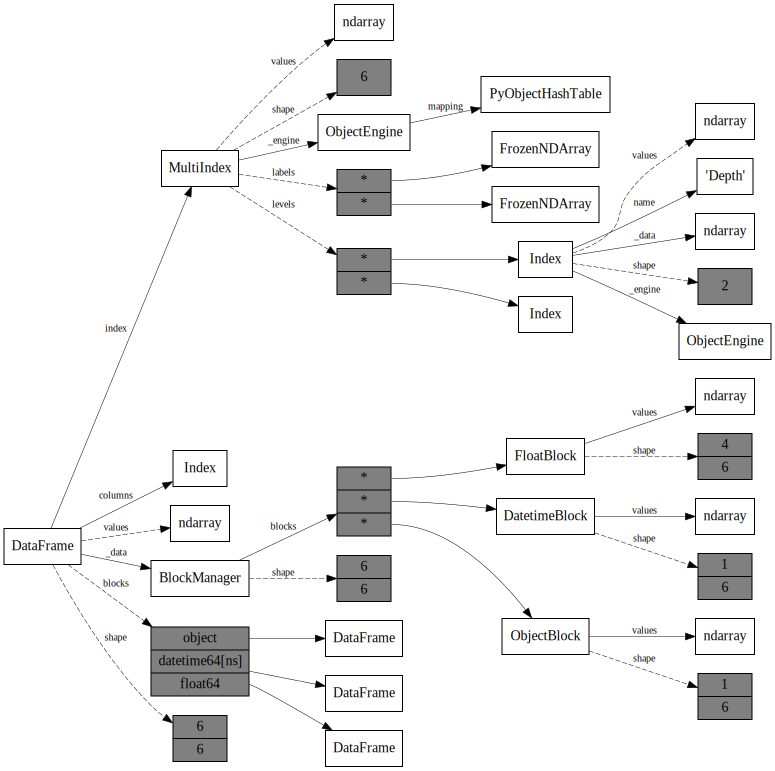

In [91]:
#%fig=DataFrame物件的內定結構
from scpy2.common import GraphvizDataFrame
%dot GraphvizDataFrame.graphviz(df_soil)

`DataFrame` 物件的 `columns` 屬性是 `Index` 物件，而 `index` 屬性是表示多級索引的 `MultiIndex` 物件。

`Index` 物件的索引功能由其 `_engine` 屬性 — 一個 `ObjectEngine` 物件提供，該物件使用一個雜湊表 `PyObjectHashTable` 物件將標籤對映到與其對應的整數索引。

下面的程式取得列標籤 "Date" 對應的整數索引：

In [35]:
df_soil.columns._engine.mapping.get_item("Date")

4

`DataFrame` 物件的資料都儲存在 `_data` 屬性中，它是一個 `BlockManager` 物件，其 `blocks` 屬性是一個清單，其中有一個 `FloatBlock` 物件, 一個 `DatetimeBlock` 物件 和 一個 `ObjectBlock` 物件。這些物件是管理實際資料的資料區塊，其 `values` 屬性是儲存資料的陣列。

`DataFrame` 物件儘量用一個陣列儲存相同型態的列，而將不同型態的列儲存在不同的陣列中。這些陣列的形狀為 `(4,6), (1,6), (1,6)`。它們的第 0 軸的長度對應 4 個浮點數列、1 個時間序列 和 1 個字串列。由此可知 `DataFrame` 中的整列資料是儲存在連續的記憶體空間中，這有助於加強資料的存取速度。

常透過 `[]` 取得某一列時，所得到的 `Series` 物件與原 `DataFrame` 物件共用記憶體。下面檢視儲存 `Series` 物件資料的陣列的 `base` 屬生，也就是 `df_soil.data.blocks[0].values`:

In [36]:
s = df_soil["Dens"]
s.values.base is df_soil._data.blocks[0].values

True

當透過 `[]` 取得多列時，將複製所有的資料，因此儲存新 `DataFrame` 物件資料的陣列的 `base` 屬性為 `None`:

In [37]:
print( df_soil[["Dens"]]._data.blocks[0].values.base )

None


如果 `DataFrame` 物件只有一個資料區塊，則透過 `values` 屬性獲得的陣列是資料區塊中陣列的轉置，因此它與 `DataFrame` 物件共用記憶體。例如在下面的程式中，`df_float` 中所有列的元素型態相同，它只有一個資料區塊，因此 `df_float.values` 所得到的陣列與 `df_float` 中儲存資料的陣列共用記憶體。

In [38]:
df_float = df_soil[['pH', 'Dens', 'Ca', 'Conduc']]
df_float.values.base is df_float._data.blocks[0].values

True

當 `DataFrame` 物件只有一個資料區塊時，取得其行資料所得到的 `Series` 物件也與其共用記憶體：

In [39]:
df_float.loc["0-10", "Top"].values.base is df_float._data.blocks[0].values

True

而當 `BlockManager` 中使用多個陣列儲存資料時，則傳回這些資料的拷貝，陣列的元素型態為最通用的元素型態，以儲存各種格式的資料。在下面的實列中，`df.values` 的元素型態為 `object` ，因為它需要同時儲存浮點數、時間和字串。

In [40]:
df_soil.values.dtype

dtype('O')